In [98]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import traceback
import os
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from collections import defaultdict

def plot_df(df, ax, column, label='', lower_cut=0):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    y = mean[column][lower_cut:]
    x = mean[column][lower_cut:].index
    ci = std[column][lower_cut:]
    ax.plot(x,y, label=label)
    ax.fill_between(x, (y-ci), (y+ci), alpha=.1)

def analyse_df(df, column, epoch):
    mean = df.T.groupby(df.T.index).mean().T
    std = df.T.groupby(df.T.index).std().T

    mean = mean[column][epoch]
    std = std[column][epoch]
    return mean, std


def parse_tensorboard(path):
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])

    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    df = runlog_data.pivot(index='step', columns='metric')
    df.columns = df.columns.levels[1]
    df = df.reset_index(drop=True)
    return df


def find_checkpoints(string='', path="runs"):
    runs = []
    for root, dirs, files in os.walk(path):
        if string in root and files:
            checkpoint = [s for s in files if "events" in s]
            if not checkpoint:
                continue
            checkpoint = checkpoint[0]
            runs.append({
                'root': root,
                'checkpoint': checkpoint,
                'path': os.path.join(root, checkpoint),
            })
    return runs

In [2]:
runs = find_checkpoints(path='/home/cermavo3/projects/datasets/experiments/metric_learning/runs')
data = defaultdict(list)

for run in runs:
    df = parse_tensorboard(run['path'])
    if df.values.size > 0:
        name = run['root'].split('/')[-2][20:]
        data[name].append(df['acc'])
        data[name].append(df['acc_bal'])

dfs = {}
for k, v in data.items():
    dfs[k] = pd.DataFrame(v).T

### ArcFace vs Basic CE

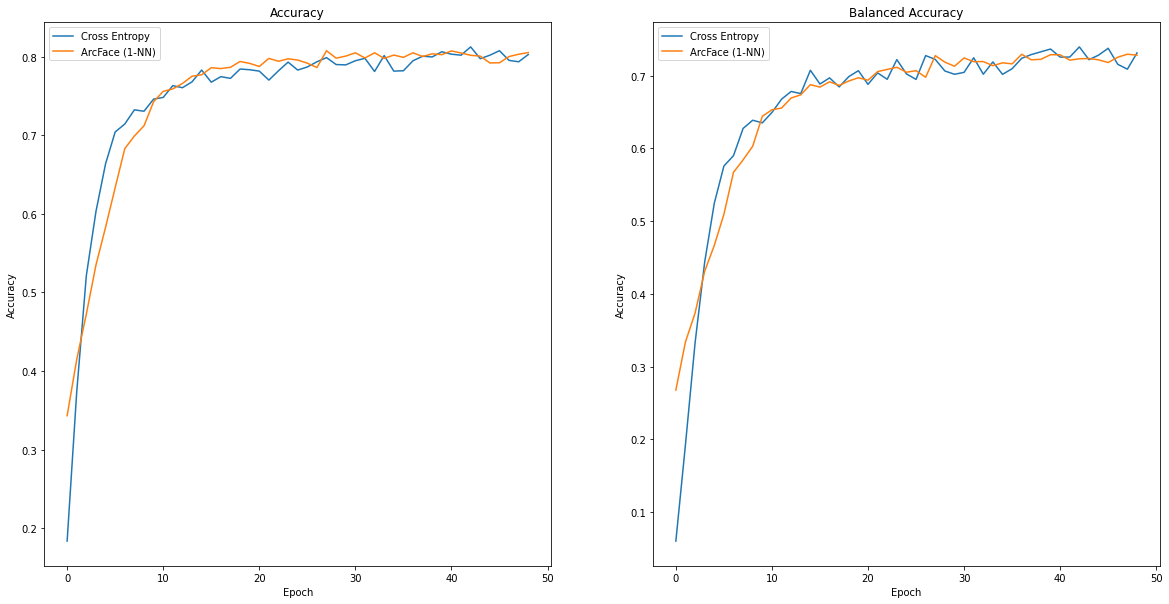

In [5]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

plot_df(dfs['baseline-ce'], ax1, label='Cross Entropy', column='acc')
plot_df(dfs['baseline-ce'], ax2, label='Cross Entropy', column='acc_bal')

plot_df(dfs['baseline-arcface'], ax1, label='ArcFace (1-NN)', column='acc')
plot_df(dfs['baseline-arcface'], ax2, label='ArcFace (1-NN)', column='acc_bal')

ax1.title.set_text('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='best')

ax2.title.set_text('Balanced Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend(loc='best')


### k-NN ArcFace

- Effect of including k nearnest neighbors instead of one nearest.

In [95]:
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append(os.path.join('configs'))
sys.path.append(os.path.join('../..'))
from baseline_arcface import *
from wildlife_training.inference import predict_knn


def knn_classifier(cls, k=1):
    df = pd.DataFrame(cls)
    return df.iloc[:, :k].mode(axis=1)[0]

def create_trainer(dataset):
    embedder = create_model(
        model_name = 'efficientnet_b0',
        pretrained = True,
        num_classes = config['embedding_size'],
        )

    loss_func = losses.ArcFaceLoss(
        num_classes = dataset.num_classes,
        embedding_size = config['embedding_size'],
        margin = 28.6,
        scale = 64,
        )

    optimizers = {
        'embedder': torch.optim.Adam(
            params=embedder.parameters(),
            lr=1e-3
            ),
        'loss': torch.optim.Adam(
            params=loss_func.parameters(),
            lr=1e-3
            ),
        }

    trainer = EmbeddingTrainer(
        embedder = embedder,
        loss_func = loss_func,
        optimizers = optimizers,
        evaluation = evaluation,
        device = 'cpu',
    )
    return trainer

trainer = create_trainer(splits[0]['train'])
root = '/home/cermavo3/projects/datasets/experiments/metric_learning'
path = f'{root}/runs/Sep15_08-14-21-4453_baseline-arcface/1/model_latest.pth'
trainer.load_checkpoint(path)


dataset_valid =  splits[0]['valid']
dataset_reference = splits[0]['reference']
pred, _ = predict_knn(trainer.embedder, dataset_reference, dataset_valid, k=50)

gt = dataset_valid.label_map[dataset_valid.label]
acc = {}
for i in tqdm(range(1, 50)):
    acc['k='+str(i)] = (knn_classifier(pred, k=i) == gt).sum() / len(gt)

pd.Series(acc).plot()

### Time dynamics

In [24]:
import numpy as np
def process_results(results, max_point=1.5, num_points=50):
    df = {}
    for threshold in np.linspace(0, max_point, num_points):
        data = {}
        for year, v in results.items():
            gt = v['gt']
            gt_new = v['gt_new']
            pred = v['pred']
            dist = v['dist']

            pred_new = dist > threshold
            acc_detection = (pred_new.astype(str) == gt_new.astype(str)).sum() / len(gt)
            acc_cls = (pred[~pred_new] == gt[~pred_new]).sum() / len(gt)
            acc_cls_gt = (pred[~gt_new] == gt[~gt_new]).sum() / len(gt)
            data[year] = {
                'acc_det':acc_detection,
                'acc_cls': acc_cls,
                'acc_cls_gt': acc_cls_gt,
            }

        df[threshold] = pd.DataFrame(data).T.mean().to_dict()
    df = pd.DataFrame(df).T
    return df

### Basic CE

In [1]:
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append(os.path.join('configs'))
sys.path.append(os.path.join('../..'))
from wildlife_training.inference import predict_knn, predict_classifier
from time_ce import *
import numpy as np
import pickle

def create_trainer(dataset):
    model = create_model(
        model_name = 'efficientnet_b0',
        pretrained = True,
        num_classes = dataset.num_classes,
        )

    optimizer = torch.optim.Adam(
        params = model.parameters(),
        lr = 1e-3
        )

    trainer = BasicTrainer(
        model = model,
        evaluation = evaluation,
        optimizer = optimizer,
        device = 'cpu',
    )
    return trainer

/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [190]:
from wildlife_training.inference import predict_knn

root = '/home/cermavo3/projects/datasets/experiments/metric_learning'
results = {}
    
for split in splits:
    trainer = create_trainer(split['train'])
    name = split['name']
    path = f'{root}/runs/Sep15_16-28-37-4981_time_ce/{name}/model_latest.pth'
    trainer.load_checkpoint(path)
    
    # Collect predictions
    trainer.model.classifier = nn.Identity()
    pred, dist = predict_knn(trainer.model, split['reference'], split['valid'])
    gt = pd.Series(split['valid'].label_map[split['valid'].label])
    new_labels = set(split['valid'].label_map) - set(split['reference'].label_map)
    results[split['name']] = {
        'gt': gt,
        'gt_new': gt.isin(new_labels),
        'pred': pd.Series(pred.flatten()),
        'dist': pd.Series(dist.flatten()),
    }

with open('time_ce.pkl', 'wb') as f:
    pickle.dump(results, f)

100%|██████████| 8/8 [00:30<00:00,  3.77s/it]


In [388]:
threshold = 0.5

data = {}
for year, d in results_ce.items():
    gt = d['gt']
    gt_new = d['gt_new']
    pred = d['pred']
    dist = d['dist']

    pred_new = dist > threshold
    acc_detection = (pred_new.astype(str) == gt_new.astype(str)).sum() / len(gt)
    acc_classification = (pred[~pred_new] == gt[~pred_new]).sum() / len(gt)
    acc_classification_gt = (pred[~gt_new] == gt[~gt_new]).sum() / len(gt)

    predict_new = pred_new.sum() / len(gt)
    data[year] = {
        'pred_new':predict_new,
        'acc_det':acc_detection,
        'acc_cls': acc_classification,
        'acc_cls_gt': acc_classification_gt,
    }

df = pd.DataFrame(data).T
df

,pred_new,acc_det,acc_cls,acc_cls_gt
2011,0.977778,0.894444,0.011111,0.094444
2012,0.920290,0.927536,0.028986,0.050725
2013,0.936782,0.683908,0.011494,0.103448
2014,0.985782,0.725118,0.014218,0.061611
2015,0.940843,0.760130,0.016207,0.045381
2016,0.924251,0.683500,0.017616,0.056958
2017,0.781356,0.577966,0.113559,0.211864
2018,0.841197,0.505178,0.118527,0.270426
2019,0.875691,0.453039,0.084715,0.240331
2020,0.845209,0.269042,0.098280,0.280098


In [390]:
threshold = 1000

data = {}
for year, d in results_arcface.items():
    gt = d['gt']
    gt_new = d['gt_new']
    pred = d['pred']
    dist = d['dist']

    pred_new = dist > threshold
    acc_detection = (pred_new.astype(str) == gt_new.astype(str)).sum() / len(gt)
    acc_classification = (pred[~pred_new] == gt[~pred_new]).sum() / len(gt)
    acc_classification_gt = (pred[~gt_new] == gt[~gt_new]).sum() / len(gt)

    predict_new = pred_new.sum() / len(gt)
    data[year] = {
        'pred_new':predict_new,
        'acc_det':acc_detection,
        'acc_cls': acc_classification,
        'acc_cls_gt': acc_classification_gt,
    }

df = pd.DataFrame(data).T
df

,pred_new,acc_det,acc_cls,acc_cls_gt
2011,0.0,0.105556,0.088889,0.088889
2012,0.0,0.050725,0.050725,0.050725
2013,0.0,0.310345,0.114943,0.114943
2014,0.0,0.289100,0.113744,0.113744
2015,0.0,0.226094,0.053485,0.053485
2016,0.0,0.304169,0.085144,0.085144
2017,0.0,0.583051,0.250847,0.250847
2018,0.0,0.609896,0.316456,0.316456
2019,0.0,0.628913,0.321363,0.321363
2020,0.0,0.863636,0.385749,0.385749


### Arcface

In [1]:
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append(os.path.join('configs'))
sys.path.append(os.path.join('../..'))
from wildlife_training.inference import predict_knn, predict_classifier
from time_arcface import *

def create_trainer(dataset):
    embedder = create_model(
        model_name = 'efficientnet_b0',
        pretrained = True,
        num_classes = config['embedding_size'],
        )

    loss_func = losses.ArcFaceLoss(
        num_classes = dataset.num_classes,
        embedding_size = config['embedding_size'],
        margin = 28.6,
        scale = 64,
        )

    optimizers = {
        'embedder': torch.optim.Adam(
            params=embedder.parameters(),
            lr=1e-3
            ),
        'loss': torch.optim.Adam(
            params=loss_func.parameters(),
            lr=1e-3
            ),
        }

    trainer = EmbeddingTrainer(
        embedder = embedder,
        loss_func = loss_func,
        optimizers = optimizers,
        evaluation = evaluation,
        device = 'cpu',
    )
    return trainer

/mnt/appl/software/torchvision/0.10.0-fosscuda-2020b-PyTorch-1.9.0/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [275]:
from wildlife_training.inference import predict_knn

root = '/home/cermavo3/projects/datasets/experiments/metric_learning'
results = {}
    
for split in splits:
    trainer = create_trainer(split['train'])
    name = split['name']
    path = f'{root}/runs/Sep15_16-50-17-4579_time_arcface/{name}/model_latest.pth'
    trainer.load_checkpoint(path)
    
    # Collect predictions
    pred, dist = predict_knn(trainer.embedder, split['reference'], split['valid'])
    gt = pd.Series(split['valid'].label_map[split['valid'].label])
    new_labels = set(split['valid'].label_map) - set(split['reference'].label_map)
    results[split['name']] = {
        'gt': gt,
        'gt_new': gt.isin(new_labels),
        'pred': pd.Series(pred.flatten()),
        'dist': pd.Series(dist.flatten()),
    }


with open('time_arcface.pkl', 'wb') as f:
    pickle.dump(results, f)


100%|██████████| 8/8 [00:31<00:00,  3.96s/it]


In [2]:
from wildlife_training.inference import predict_knn, predict_arcface

root = '/home/cermavo3/projects/datasets/experiments/metric_learning'
results = {}
    
for split in splits:
    trainer = create_trainer(split['train'])
    name = split['name']
    path = f'{root}/runs/Sep15_16-50-17-4579_time_arcface/{name}/model_latest.pth'
    trainer.load_checkpoint(path)

    # Collect predictions
    pred, dist = predict_arcface(trainer.embedder, trainer.loss_func, split['reference'], split['valid'])
    gt = pd.Series(split['valid'].label_map[split['valid'].label])
    new_labels = set(split['valid'].label_map) - set(split['reference'].label_map)
    results[split['name']] = {
        'gt': gt,
        'gt_new': gt.isin(new_labels),
        'pred': pd.Series(pred.flatten()),
        'dist': pd.Series(dist.flatten()),
    }

import pickle
with open('time_arcface_w.pkl', 'wb') as f:
    pickle.dump(results, f)

100%|██████████| 8/8 [01:58<00:00, 14.76s/it]


,acc_det,acc_cls,acc_cls_gt
count,50.000000,50.000000,5.000000e+01
mean,0.546751,0.109505,1.701171e-01
std,0.066734,0.069285,2.803737e-17
min,0.452458,0.000000,1.701171e-01
25%,0.480342,0.035903,1.701171e-01
50%,0.549127,0.149710,1.701171e-01
75%,0.601527,0.170117,1.701171e-01
max,0.650130,0.170117,1.701171e-01


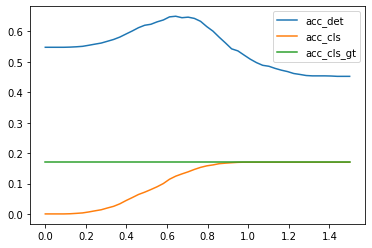

In [34]:
with open('time_ce.pkl', 'rb') as f:
    results =  pickle.load(f)
df = process_results(results)

df.plot()
df.describe()

,acc_det,acc_cls,acc_cls_gt
count,50.000000,50.000000,5.000000e+01
mean,0.608029,0.083921,2.055920e-01
std,0.036645,0.071108,8.411210e-17
min,0.548047,0.000000,2.055920e-01
25%,0.575593,0.006298,2.055920e-01
50%,0.622821,0.077417,2.055920e-01
75%,0.636089,0.160231,2.055920e-01
max,0.654481,0.177616,2.055920e-01


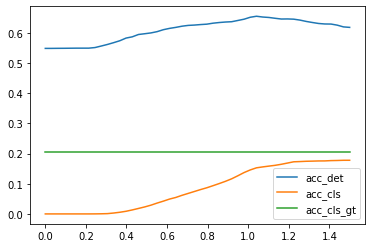

In [37]:
with open('time_arcface_w.pkl', 'rb') as f:
    results =  pickle.load(f)
df = process_results(results)

df.plot()
df.describe()

,acc_det,acc_cls,acc_cls_gt
count,50.000000,50.000000,5.000000e+01
mean,0.513536,0.139447,2.133949e-01
std,0.046465,0.065723,2.523363e-16
min,0.447778,0.000000,2.133949e-01
25%,0.460175,0.090599,2.133949e-01
50%,0.526683,0.151738,2.133949e-01
75%,0.557217,0.200625,2.133949e-01
max,0.569455,0.213290,2.133949e-01


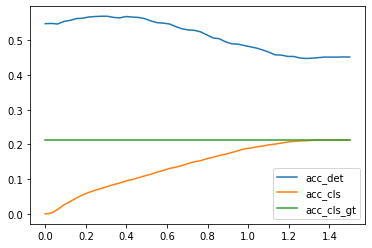

In [36]:
with open('time_arcface.pkl', 'rb') as f:
    results =  pickle.load(f)
df = process_results(results)

df.plot()
df.describe()

### Arcface - inference

In [3]:
from tqdm import tqdm
import pandas as pd

import os
import sys
sys.path.append(os.path.join('configs'))
sys.path.append(os.path.join('../..'))
from wildlife_training.inference import predict_knn, predict_classifier
from baseline_arcface import *

def create_trainer(dataset):
    embedder = create_model(
        model_name = 'efficientnet_b0',
        pretrained = True,
        num_classes = config['embedding_size'],
        )

    loss_func = losses.ArcFaceLoss(
        num_classes = dataset.num_classes,
        embedding_size = config['embedding_size'],
        margin = 28.6,
        scale = 64,
        )

    optimizers = {
        'embedder': torch.optim.Adam(
            params=embedder.parameters(),
            lr=1e-3
            ),
        'loss': torch.optim.Adam(
            params=loss_func.parameters(),
            lr=1e-3
            ),
        }

    trainer = EmbeddingTrainer(
        embedder = embedder,
        loss_func = loss_func,
        optimizers = optimizers,
        evaluation = evaluation,
        device = 'cpu',
    )
    return trainer

In [34]:
split = splits[0]
trainer = create_trainer(split['train'])
root = '/home/cermavo3/projects/datasets/experiments/metric_learning'
path = f'{root}/runs/Sep15_08-14-21-4453_baseline-arcface/1/model_latest.pth'
trainer.load_checkpoint(path)

w = trainer.loss_func.W
w.requires_grad = False

In [39]:
from torch.utils.data import DataLoader

In [40]:
loader = DataLoader(split['train'], shuffle=False, batch_size=64)

In [48]:
x, y = next(iter(loader))
with torch.no_grad():
    x = trainer.embedder(x)

In [114]:
pred_knn = predict_knn(trainer.embedder, split['reference'], split['valid'])

100%|██████████| 60/60 [14:06<00:00, 14.11s/it]


In [113]:
pred_arcface = predict_arcface(trainer.embedder, trainer.loss_func, split['reference'], split['valid'])

100%|██████████| 60/60 [14:43<00:00, 14.72s/it]


In [117]:
gt = split['valid'].label_map[split['valid'].label]

In [130]:
(pred_arcface[0].flatten() == gt).sum() / len(gt)

0.8060686015831134

In [131]:
(pred_knn[0].flatten() == gt).sum() / len(gt)

0.8142480211081794

In [112]:

import numpy as np
def prepare_batch(batch, device='cpu'):
    if isinstance(batch, list):
        x, y = batch
    else:
        raise NotImplementedError('Batch needs to be (x, y) tuple.')

    if isinstance(x, list):
        x = [tensor.to(device) for tensor in x]
    else:
        x = x.to(device)

    y = y.to(device)
    return x, y

def predict_arcface(
    embedder,
    loss_func,
    dataset_train,
    dataset_valid,
    score_func=None,
    k=1,
    batch_size=64,
    num_workers=0,
    device='cpu',
    **kwargs
    ):
    '''
    Calculates top K predictions using cosine similarity to arcface W matrix.

    Example:
        predicted, _ = predict_arcface(classifier, dataset_train, dataset_valid)
        actual = dataset_valid.label_map[dataset_valid.label]
        calculate_accuracy(actual, predicted)
    '''
    embedder = embedder.eval()
    predicted, scores = [], []
    loader = DataLoader(dataset_valid, shuffle=False, batch_size=batch_size, num_workers=num_workers)
    w_norm = F.normalize(loss_func.W)

    for batch in tqdm(loader):
        x, _ = prepare_batch(batch, device=device)
        with torch.no_grad():
            x_norm = F.normalize(embedder(x))
            score = torch.matmul(x_norm, w_norm)

        # Calculate score
        score, index = score.topk(k, dim=1)
        predicted.append(dataset_train.label_map[index.numpy()])
        scores.append(score.numpy())

    predicted = np.concatenate(predicted)
    scores = np.concatenate(scores)
    return predicted, scores